In [92]:
import datetime as dt
from dataclasses import dataclass
from typing import TypedDict
from enum import Enum

@dataclass
class ChickTimerStatus():
    DaysSinceStatusChanged: int
    DaysSinceHatch: int
    DaysSinceDesertionTriggered: int
    TimeOfEmergence: int
    WeeksOfBatteryLeft: int
    ActivityYesterday: int
    ActivityTwoDaysAgo: int
    MeanActivity: int

    def getValues(self):
        return [self.DaysSinceStatusChanged, self.DaysSinceHatch, \
                self.DaysSinceDesertionTriggered, self.TimeOfEmergence, \
                self.WeeksOfBatteryLeft, self.ActivityYesterday, \
                self.ActivityTwoDaysAgo, self.MeanActivity]

class ChickTimerMode(Enum):
    NotIncubating = 30
    Incubating = 48
    Mortality = 80

class ChickTimer():
    status : ChickTimerStatus
    channel : int
    mode: ChickTimerMode

    def __init__(self):
        self.status = ChickTimerStatus(
            DaysSinceStatusChanged = 0,
            DaysSinceHatch = 0,
            DaysSinceDesertionTriggered = 0,
            TimeOfEmergence = 0,
            WeeksOfBatteryLeft = 0,
            ActivityYesterday = 0,
            ActivityTwoDaysAgo = 0,
            MeanActivity = 0
        )
        self.channel = 0
        self.mode = ChickTimerMode.NotIncubating

    def __str__(self):
        return f'ChickTimer:\n\t{self.status}\n\tMode: {self.mode}\n\tChannel: {self.channel}'

In [93]:
ct = ChickTimer()
ct.mode = ChickTimerMode.Incubating
ct.status.DaysSinceStatusChanged = 5
ct.status.DaysSinceHatch = 3
ct.status.DaysSinceDesertionTriggered = 0
ct.status.TimeOfEmergence = 10
ct.status.WeeksOfBatteryLeft = 15
ct.status.ActivityYesterday = 54
ct.status.ActivityTwoDaysAgo = 49
ct.status.MeanActivity = 51

print(ct)

ChickTimer:
	ChickTimerStatus(DaysSinceStatusChanged=5, DaysSinceHatch=3, DaysSinceDesertionTriggered=0, TimeOfEmergence=10, WeeksOfBatteryLeft=15, ActivityYesterday=54, ActivityTwoDaysAgo=49, MeanActivity=51)
	Mode: ChickTimerMode.Incubating
	Channel: 0


In [94]:
TENS_VALUE_START_PULSE  = [20] # BPM
ONES_VALUE_START_PULSE  = [16] # BPM
REGULAR_DATA_PULSE      = [80] # BPM
MODE_START_PULSE        = [16] # BPM

def encodeField(value : int) -> list:
    zero_offset = 2
    tens_digit = int(value/10) + zero_offset
    ones_digit = value % 10 + zero_offset
    return TENS_VALUE_START_PULSE + REGULAR_DATA_PULSE*(tens_digit - 1) + \
           ONES_VALUE_START_PULSE + REGULAR_DATA_PULSE*(ones_digit - 1)

def encodeMode(mode : ChickTimerMode):
    return MODE_START_PULSE + [mode.value]*(4)

def encodeChickTimerStatus(ct: ChickTimer):
    bpm_encoding = list()
    for field in ct.status.getValues():
        bpm_encoding.extend(encodeField(field))
        bpm_encoding.extend(encodeMode(ct.mode))
    # Trim extra mode beeps from the end
    return bpm_encoding[:-4]

In [95]:
print(encodeField(ct.status.MeanActivity))
print(encodeMode(ct.mode))
print(encodeChickTimerStatus(ct))

[20, 80, 80, 80, 80, 80, 80, 16, 80, 80]
[16, 48, 48, 48, 48]
[20, 80, 16, 80, 80, 80, 80, 80, 80, 16, 48, 48, 48, 48, 20, 80, 16, 80, 80, 80, 80, 16, 48, 48, 48, 48, 20, 80, 16, 80, 16, 48, 48, 48, 48, 20, 80, 80, 16, 80, 16, 48, 48, 48, 48, 20, 80, 80, 16, 80, 80, 80, 80, 80, 80, 16, 48, 48, 48, 48, 20, 80, 80, 80, 80, 80, 80, 16, 80, 80, 80, 80, 80, 16, 48, 48, 48, 48, 20, 80, 80, 80, 80, 80, 16, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 16, 48, 48, 48, 48, 20, 80, 80, 80, 80, 80, 80, 16, 80, 80, 16]


In [96]:
# Generate a test signal with the ChickTimer Status Burst
import numpy as np

# Configurable values
beep_duration = 0.0185 # seconds
sample_rate = 10240 # Hz
beep_power = -10 # dBFS
tone_freq = 500 # Hz

beeps = [ct.mode.value]*10 + encodeChickTimerStatus(ct) + [ct.mode.value]*10

# Calculated values
beep_power_linear = 10 ** (beep_power / 10.0)

# Generate the samples for single beep
t = np.linspace(0, beep_duration, np.round(beep_duration * sample_rate).astype(int), endpoint=False, dtype=np.complex64)
beep_signal = beep_power_linear * np.exp(2j * np.pi * tone_freq * t)
n_samps_beep = len(beep_signal)

ch_signal = np.zeros(np.random.randint(sample_rate), dtype=np.complex64)
for beep in beeps:
    ch_signal = np.append(ch_signal, beep_signal)
    n_samps_beep_period = np.round(60 / beep * sample_rate).astype(int)
    ch_signal = np.append(ch_signal, [0]*(n_samps_beep_period - n_samps_beep))

In [97]:
if False:
    np.save("test_ct_signal", ch_signal.astype(np.complex128))

    iq_fc32 = ch_signal.astype(np.complex64)

    with open(f'test_ct_signal.fc32', 'wb') as f:
        f.write(iq_fc32.tobytes())

In [98]:
# Process the signal, detect peaks and calculate pulse rates
import scipy as sp 

signal = ch_signal

mag_samples = np.abs(signal)
match_filtered = sp.signal.convolve(mag_samples, [1]*185, 'valid')
peaks = sp.signal.find_peaks(match_filtered, prominence=2)[0]

pulse_intervals = [(peak2 - peak1) / sample_rate for (peak1, peak2) in zip(peaks[:-1], peaks[1:])]
bpms = [60 / interval for interval in pulse_intervals]
pulse_intervals_ms = [i * 1000 for i in pulse_intervals]

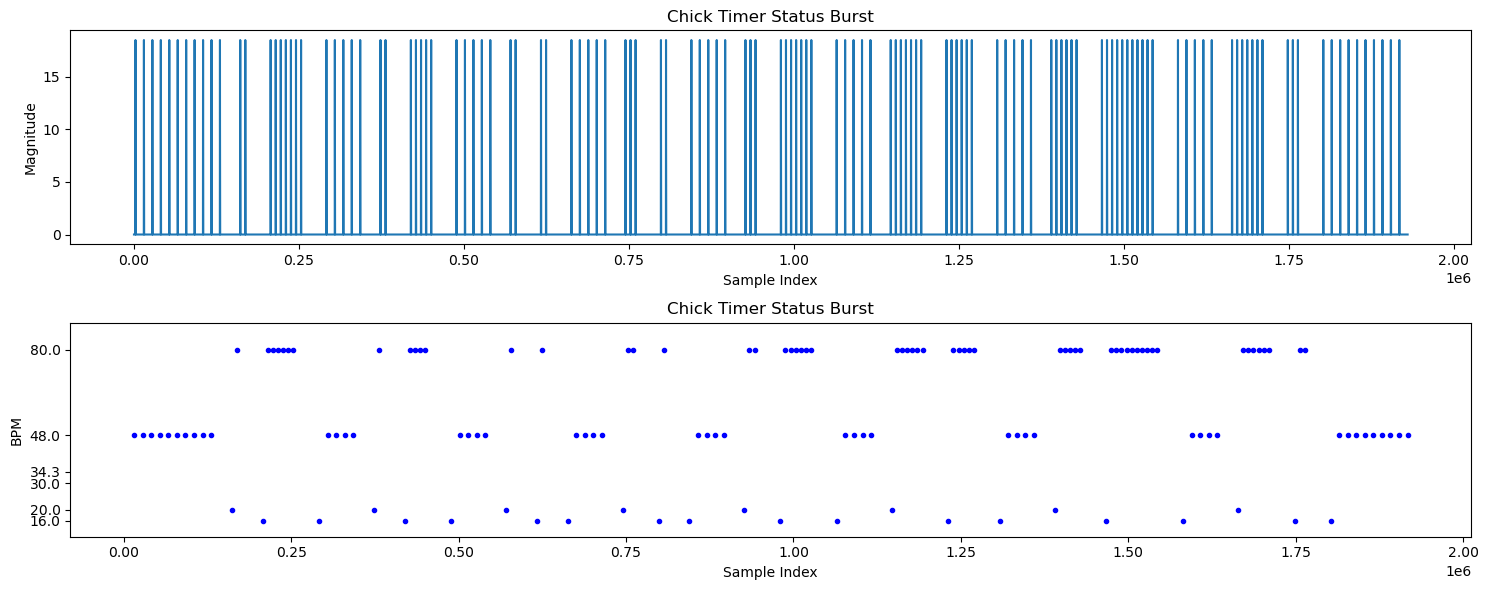

In [99]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(2,1, figsize=(15,6))

ax = axes[0]
ax.plot(match_filtered[:])
ax.set_xlabel("Sample Index")
ax.set_ylabel("Magnitude")
ax.set_title("Chick Timer Status Burst")

marker = '.' # 'o'
linewidth = 0.0

valid_intervals = [250, 750, 1250, 1750, 2000, 3000, 3750]
valid_BPMs = [60 / (interval / 1000) for interval in valid_intervals]


ax = axes[1]
ax.plot(peaks[1:], bpms, label='BPMs', marker=marker, lw=linewidth, color='blue')

ax.set_xlabel("Sample Index")
ax.set_ylabel("BPM")
ax.set_yticks(valid_BPMs)
ax.set_ylim([10, 90])
ax.set_title("Chick Timer Status Burst")

plt.tight_layout()
plt.show()